# Training with PyTorch

## Dataset and DataLoader

These classes encapsulate process of pulling data from storageand exposing it to training loop in batches.

`Dataset` reponsible for accessing, processing single instances of data.

`DataLoader` pulls data instances from `Dataset`, collects them in batches, returns them for consumption by training loop.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5))]
)

# Create datasets for training/validation, download if needed
training_set = torchvision.datasets.FashionMNIST(
    "./data", train=True, transform=transform, download=True
)
validation_set = torchvision.datasets.FashionMNIST(
    "./data", train=False, transform=transform, download=True
)

# Create dataloaders for datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(
    training_set, batch_size=4, shuffle=True, num_workers=2
)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=4, shuffle=False, num_workers=2
)

# Class labels
classes = (
    "T-shirt/top",
    "Trousers",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boot",
)

# Report split sizes
print(f"Training set has {len(training_set)} instances")
print(f"Validation set has {len(validation_set)} instances")


Training set has 60000 instances
Validation set has 10000 instances


Trousers  Dress  Sneaker  Coat


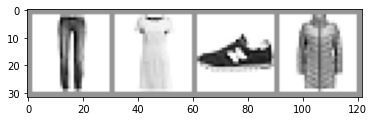

In [4]:
# Visualise data as sanity check

import matplotlib.pyplot as plt
import numpy as np

def mpl_imshow(img, one_channel=False):

    if one_channel:
        img = img.mean(dim=0)  # un-normalise

    npimg = img.numpy()

    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
imgs, labels = dataiter.next()

# Create grid from imgs and show them
img_grid = torchvision.utils.make_grid(imgs)
mpl_imshow(img_grid, one_channel=True)
print("  ".join(classes[labels[j]] for j in range(4)))

## The Model

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

## Loss Function

Using cross-entropy loss. For demo, will create batches of dummy output and label values, run them through loss func, examine result.

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

# Loss functions expect data in batches so creating batches of 4

dummy_outputs = torch.rand(4, 10)  # represents model's confidence in each class for given input
dummy_labels = torch.tensor([1, 5, 3, 7])